In [2]:
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
# import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.font_manager
from scipy.integrate import simps
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
from scipy.stats import skew,kurtosis

import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'normal','size': 14}
plt.rc('font', **font)
plt.rc('figure', titlesize=14)

if 'imac' in os.getcwd():
    macFlag=True
else:
    macFlag=False

if not macFlag:
    rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
    rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
    rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
else:
    rootAddress= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38"
    rootAddressAllData='/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Selected-38'
    rootAddressSanitized='/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Selected-38/TestDays_'

rootPrefix=r"C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\38"
if not os.path.exists(rootPrefix):
    rootPrefix='/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/38/'
if not os.path.exists(rootPrefix):
    rootPrefix='/home/grads/s/sorush.omidvar/CGMDataset/38/'

hoomanFile=r'/home/grads/s/sorush.omidvar/CGMDataset/38/HoomanCGM.xlsx'

#Setting the testdays for each participant, the days are in order. Meaning that the first day is Meal 1 and so on.
testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,6),datetime(2018,9,13),datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,20),datetime(2018,9,11),datetime(2018,9,17),datetime(2018,9,5),datetime(2018,9,4)],
           [datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,25),datetime(2018,9,13),datetime(2018,10,3),datetime(2018,10,2),datetime(2018,9,27),datetime(2018,9,17),datetime(2018,9,26)],
           [datetime(2018,10,4),datetime(2018,10,9),datetime(2018,9,25),datetime(2018,10,11),datetime(2018,9,26),datetime(2018,10,3),datetime(2018,10,10),datetime(2018,9,27),datetime(2018,10,2)]
           ]).astype(datetime)
           
#Convert the datetime to day of year and the second element is the meal number
testDaysMealNumbers=np.zeros((7,9,2))
for i in range(7):
    for j in range(9):
        tempDay=testDays[i,j]
        testDaysMealNumbers[i,j,0]=tempDay.timetuple().tm_yday
        testDaysMealNumbers[i,j,1]=j

In [76]:

# This cell predicts the BG for a slidding window 
myDf=pd.read_excel(hoomanFile)
def bgPredictionSliddingWindow(myDf):
    participants=myDf["PatientID"].to_list()
   
    participants=list(set(participants))
    print(participants)
    horizons=[15,30,45,60]
    windowShift=120
    
    for horizon in horizons:
        sliddingWindow=[]
        sliddingWindowLabel=[]
        for participant in participants:
            participantDf=myDf[myDf['PatientID']==participant]
            
            meals=myDf["Meal"].to_list()
            meals=list(set(meals))
            
            for meal in meals:
                mealDf=participantDf[participantDf['Meal']==meal]         
                
                for counter in range(2,480+45-120-horizon-10,windowShift):
                    startColumn=counter
                    endColumn=startColumn+120
                    tempVal=mealDf.iloc[:,startColumn:endColumn].values.flatten().tolist()
                    if len(tempVal)<120:
                        continue
                    sliddingWindow.append(tempVal)

                    tempVal=mealDf.iloc[:,endColumn+horizon].values.flatten().tolist()
                    sliddingWindowLabel.extend(tempVal)
                
    
        sliddingWindow=np.asarray(sliddingWindow)
        sliddingWindowLabel=np.asarray(sliddingWindowLabel)
        print(sliddingWindow.shape,sliddingWindowLabel.shape)

        xTrain, xTest, yTrain, yTest = train_test_split(sliddingWindow, sliddingWindowLabel, test_size=0.33, random_state=42)
        clf = RandomForestRegressor(max_depth=8, random_state=0,n_estimators=100)
        clf.fit(xTrain, yTrain)
        yPred=clf.predict(xTest)
        msre=(yTest-yPred)
        msre=msre**2
        msre=np.mean(msre)
        msre=np.sqrt(msre)
        print('Horizon:',horizon)
        print("MSRE=",msre)
        print("Pearson and p-Val",pearsonr(yPred,yTest))
        print('---------------------------')

bgPredictionSliddingWindow(myDf)


['38E', '38Q', '38I', '38L', '38J', '38B', '38M', '38P', '38H', '38F', '38D', '38C', '38A', '38O', '38N']
(528, 120) (528,)
Horizon: 15
MSRE= 6.183296858538639
Pearson and p-Val (0.9807293451654739, 1.286947863552454e-124)
---------------------------
(528, 120) (528,)
Horizon: 30
MSRE= 11.56906767085201
Pearson and p-Val (0.9264414415774405, 2.571656986211909e-75)
---------------------------
(396, 120) (396,)
Horizon: 45
MSRE= 14.01533680863192
Pearson and p-Val (0.8848893895568734, 1.2470383156177105e-44)
---------------------------
(396, 120) (396,)
Horizon: 60
MSRE= 16.661461699509573
Pearson and p-Val (0.8275348924646113, 3.837697720790543e-34)
---------------------------


-------------------------------
Eating Block starts at: -45  min in comparison to meal time


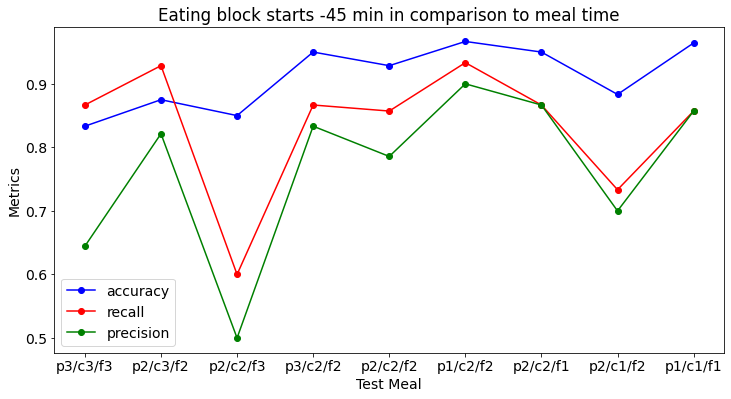

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.833333  0.866667   0.644444
7  p2/c3/f2   1071.0  0.875000  0.928571   0.821429
5  p2/c2/f3    967.0  0.850000  0.600000   0.500000
0  p3/c2/f2    853.0  0.950000  0.866667   0.833333
2  p2/c2/f2    733.0  0.928571  0.857143   0.785714
4  p1/c2/f2    673.0  0.966667  0.933333   0.900000
6  p2/c2/f1    616.0  0.950000  0.866667   0.866667
3  p2/c1/f2    563.0  0.883333  0.733333   0.700000
1  p1/c1/f1    386.0  0.964286  0.857143   0.857143
-------------------------------
Eating Block starts at: -30  min in comparison to meal time


<Figure size 432x288 with 0 Axes>

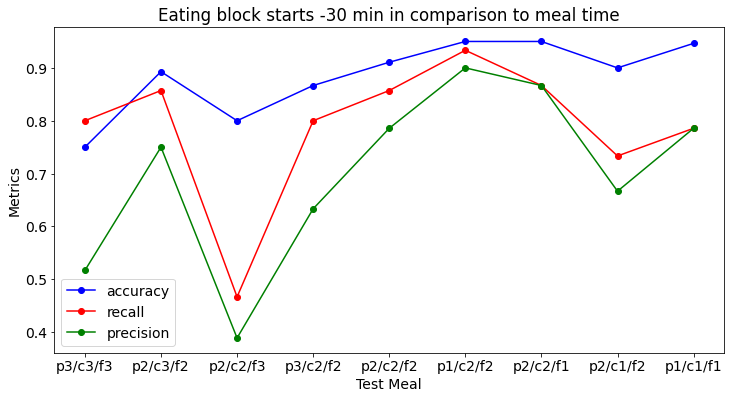

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.750000  0.800000   0.516667
7  p2/c3/f2   1071.0  0.892857  0.857143   0.750000
5  p2/c2/f3    967.0  0.800000  0.466667   0.388889
0  p3/c2/f2    853.0  0.866667  0.800000   0.633333
2  p2/c2/f2    733.0  0.910714  0.857143   0.785714
4  p1/c2/f2    673.0  0.950000  0.933333   0.900000
6  p2/c2/f1    616.0  0.950000  0.866667   0.866667
3  p2/c1/f2    563.0  0.900000  0.733333   0.666667
1  p1/c1/f1    386.0  0.946429  0.785714   0.785714
-------------------------------
Eating Block starts at: -15  min in comparison to meal time


<Figure size 432x288 with 0 Axes>

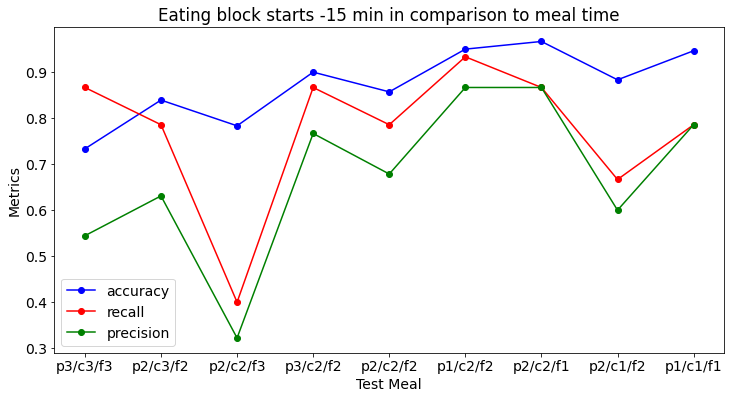

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.733333  0.866667   0.544444
7  p2/c3/f2   1071.0  0.839286  0.785714   0.630952
5  p2/c2/f3    967.0  0.783333  0.400000   0.322222
0  p3/c2/f2    853.0  0.900000  0.866667   0.766667
2  p2/c2/f2    733.0  0.857143  0.785714   0.678571
4  p1/c2/f2    673.0  0.950000  0.933333   0.866667
6  p2/c2/f1    616.0  0.966667  0.866667   0.866667
3  p2/c1/f2    563.0  0.883333  0.666667   0.600000
1  p1/c1/f1    386.0  0.946429  0.785714   0.785714
-------------------------------
Eating Block starts at: 0  min in comparison to meal time


<Figure size 432x288 with 0 Axes>

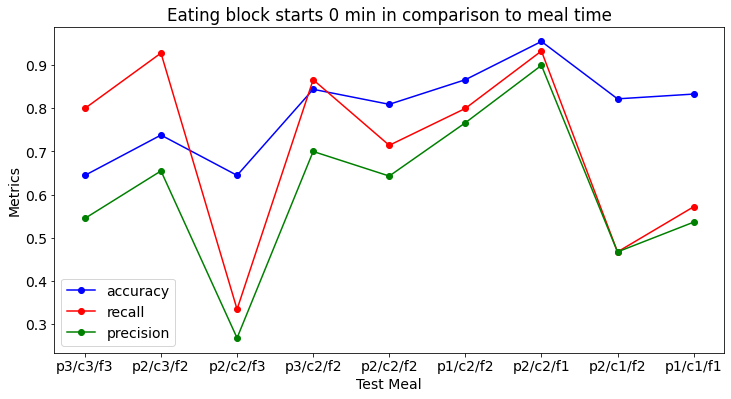

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.644444  0.800000   0.544444
7  p2/c3/f2   1071.0  0.738095  0.928571   0.654762
5  p2/c2/f3    967.0  0.644444  0.333333   0.266667
0  p3/c2/f2    853.0  0.844444  0.866667   0.700000
2  p2/c2/f2    733.0  0.809524  0.714286   0.642857
4  p1/c2/f2    673.0  0.866667  0.800000   0.766667
6  p2/c2/f1    616.0  0.955556  0.933333   0.900000
3  p2/c1/f2    563.0  0.822222  0.466667   0.466667
1  p1/c1/f1    386.0  0.833333  0.571429   0.535714
-------------------------------
Eating Block starts at: 15  min in comparison to meal time


<Figure size 432x288 with 0 Axes>

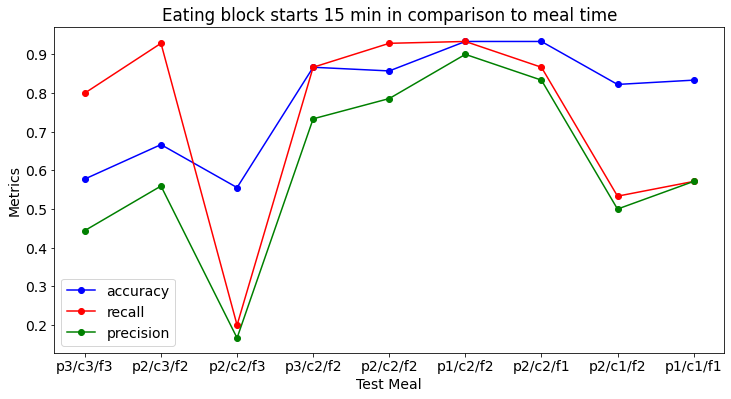

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.577778  0.800000   0.444444
7  p2/c3/f2   1071.0  0.666667  0.928571   0.559524
5  p2/c2/f3    967.0  0.555556  0.200000   0.166667
0  p3/c2/f2    853.0  0.866667  0.866667   0.733333
2  p2/c2/f2    733.0  0.857143  0.928571   0.785714
4  p1/c2/f2    673.0  0.933333  0.933333   0.900000
6  p2/c2/f1    616.0  0.933333  0.866667   0.833333
3  p2/c1/f2    563.0  0.822222  0.533333   0.500000
1  p1/c1/f1    386.0  0.833333  0.571429   0.571429
-------------------------------
Eating Block starts at: 30  min in comparison to meal time


<Figure size 432x288 with 0 Axes>

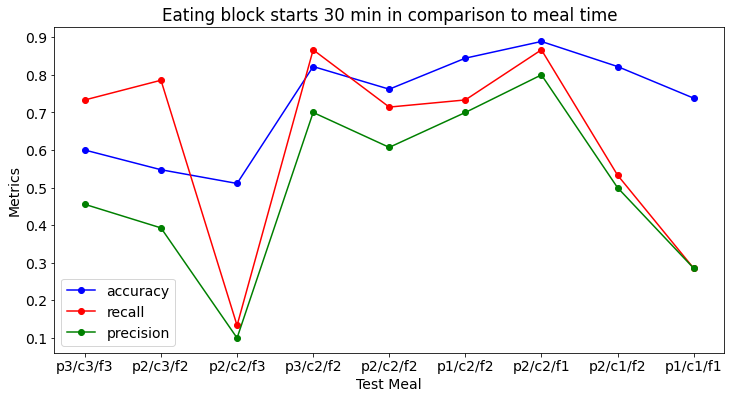

       Meal  Calorie  Accuracy    Recall  Precision
8  p3/c3/f3   1425.0  0.600000  0.733333   0.455556
7  p2/c3/f2   1071.0  0.547619  0.785714   0.392857
5  p2/c2/f3    967.0  0.511111  0.133333   0.100000
0  p3/c2/f2    853.0  0.822222  0.866667   0.700000
2  p2/c2/f2    733.0  0.761905  0.714286   0.607143
4  p1/c2/f2    673.0  0.844444  0.733333   0.700000
6  p2/c2/f1    616.0  0.888889  0.866667   0.800000
3  p2/c1/f2    563.0  0.822222  0.533333   0.500000
1  p1/c1/f1    386.0  0.738095  0.285714   0.285714


<Figure size 432x288 with 0 Axes>

In [22]:
# This function only visualize the accuracy results for each meal
def mealSummaryVisual(myDf,offset):
    fig=plt.figure(figsize=(12,6))
    meal=myDf["Meal"].tolist()
    accuracy=myDf["Accuracy"].tolist()
    recall=myDf["Recall"].tolist()
    precision=myDf["Precision"].tolist()

    plt.plot(meal,accuracy,marker='o', color='b',label="accuracy")
    plt.plot(meal,recall,marker='o', color='r',label="recall")
    plt.plot(meal,precision,marker='o', color='g',label="precision")
    plt.xlabel('Test Meal')
    plt.ylabel('Metrics')
    titleStr="Eating block starts "+str(offset)+" min in comparison to meal time"
    plt.title(titleStr)
    plt.legend()
    plt.show()
    fileName=str(offset)+".png"
    fig.savefig(fileName)

    return
#This function calculate the calaroie of each meal 
def mealCalorieCalc(meal):
    mealCalorie=0
    meal=meal.lower()
    carb=[52.25*4,94.75*4,179.25*4]
    protein=[15*4,30*4,60*4]
    fat=[13*9,26*9,52*9]
    if "c1" in meal:
        mealCalorie+=carb[0]
    elif "c2" in meal:
        mealCalorie+=carb[1]
    elif "c3" in meal:
        mealCalorie+=carb[2]
    else:
        print("Error in calorie")

    if "p1" in meal:
        mealCalorie+=protein[0]
    elif "p2" in meal:
        mealCalorie+=protein[1]
    elif "p3" in meal:
        mealCalorie+=protein[2]
    else:
        print("Error in calorie")

    if "f1" in meal:
        mealCalorie+=fat[0]
    elif "f2" in meal:
        mealCalorie+=fat[1]
    elif "f3" in meal:
        mealCalorie+=fat[2]
    else:
        print("Error in calorie")

    return mealCalorie

#This function summarize the results by averaging over participants to calculate the acc, recall and precision for each meal
def resultSummarizer(myDf,offset):
    participants=myDf['Participant'].tolist()
    participants=list(set(participants))
    meals=myDf['TestMeal'].tolist()
    meals=list(set(meals))

    summarizedResult=[]
    for meal in meals:
        mealCalorie=mealCalorieCalc(meal)
        mealDf=myDf[myDf["TestMeal"]==meal]
        accuracy=mealDf["Accuracy"].mean()
        recall=mealDf["Recall"].mean()
        precision=mealDf["Precision"].mean()
        summarizedResult.append([meal,mealCalorie,accuracy,recall,precision])
    summarizedResultDf=pd.DataFrame(summarizedResult,columns=["Meal","Calorie","Accuracy","Recall","Precision"])
    summarizedResultDf.sort_values(by=['Calorie'],inplace=True,ascending=False)
    mealSummaryVisual(summarizedResultDf,offset)
    return summarizedResultDf

#Setting Random Forest algorithm and testing all hyper-parameters
def randomForest(xTrain,xTest,yTrain,yTest):
    clf=RandomForestClassifier(n_estimators=120,criterion='entropy',random_state=20,max_depth=7)
    clf.fit(xTrain,yTrain)
    yPred=clf.predict(xTest)
    
    accuracy=sklearn.metrics.accuracy_score(yTest,yPred)
    precision=sklearn.metrics.precision_score(yTest,yPred)
    recall=sklearn.metrics.recall_score(yTest,yPred)

    return accuracy,precision,recall

#Balacing the slidingWindow data using SMOTE
def dataBalancer(x,y):
    oversample = SMOTE()
    x, y = oversample.fit_resample(x, y)
    return x, y

#This function split the data into test and train with one day out for testing for each participant
def splitter(processedDf):
    participants=processedDf['Participant'].tolist()
    participants=list(set(participants))
    predictionResult=[]
    for participant in participants:
        participantDf=processedDf[processedDf['Participant']==participant]
        meals=participantDf['Meal'].tolist()
        meals=list(set(meals))
        for meal in meals:
            trainDf=participantDf[participantDf['Meal']!=meal]
            testDf=participantDf[participantDf['Meal']==meal]

            xTrain=trainDf.iloc[:,3:].values
            yTrain=trainDf.iloc[:,2].values

            xTest=testDf.iloc[:,3:].values
            yTest=testDf.iloc[:,2].values

            xTrain,yTrain=dataBalancer(xTrain,yTrain)
            # shuffled = list(zip(xTrain, yTrain))
            # random.shuffle(shuffled)
            # xTrain, yTrain= zip(*shuffled)

            tempVal=[participant,meal]
            tempVal.extend(randomForest(xTrain,xTest,yTrain,yTest))
            predictionResult.append(tempVal)
    predictionResultDf=pd.DataFrame(predictionResult,columns=["Participant","TestMeal","Accuracy","Precision","Recall"])
    return predictionResultDf

#Calculating the statistics for each sliding window
def statCalculator(BGTimeSeries):
    windowChangeValue=BGTimeSeries[-1]-BGTimeSeries[0]
    integralValue=simps(BGTimeSeries)
    maxSlopeValue=np.max(np.diff(BGTimeSeries))
    minSlopeValue=np.min(np.diff(BGTimeSeries))
    
    maxConcavityValue=np.max(np.diff(BGTimeSeries,2))
    minConcavityValue=np.max(np.diff(BGTimeSeries,2))
    
    meanValue=np.mean(BGTimeSeries)
    stdValue=np.std(BGTimeSeries)
    skewnessValue=skew(BGTimeSeries)
    kurtosisValue=kurtosis(BGTimeSeries)
    minValue=np.min(BGTimeSeries)
    maxValue=np.max(BGTimeSeries)
    rangeValue=np.max(BGTimeSeries)-np.min(BGTimeSeries)

    features=[windowChangeValue,integralValue,maxSlopeValue,minSlopeValue,maxConcavityValue,minConcavityValue,meanValue,stdValue,skewnessValue,kurtosisValue,minValue,maxValue,rangeValue]
    featureNames=["Change","Int","MaxDiff","MinDiff","MaxConcav","MinConcav","Mean","Std","Skew","Kurtosis","Min","Max","Range"]
    return features,featureNames

#This function extracts the statistical features of each slidding window
def featureExtractor(sliddingWindow,sliddingWindowLabel,sliddingWindowMeal,sliddingWindowParticipant):
    features=[]
    for element in sliddingWindow:
        tempVal,featureNames=statCalculator(element)
        features.append(tempVal)
    features=np.asarray(features)

    processedDf=pd.DataFrame(features,columns=featureNames)    
    processedDf.insert(0,"Participant",sliddingWindowParticipant)
    processedDf.insert(1,"Meal",sliddingWindowMeal)
    processedDf.insert(2,"Label",sliddingWindowLabel)
    processedDf.to_csv(os.path.join(rootPrefix,"ProcessedHoomanBased.csv"),index=False)
    return processedDf

#This function makes slidding window and its elements give the BG and if the window contained an eating moment
def sliddingWindowMaker(df,offset,windowSize):
    participants=df["PatientID"].to_list()
    participants=list(set(participants))
    sliddingWindowBG=[]
    sliddingWindowLabel=[]
    sliddingWindowMeal=[]
    sliddingWindowParticipant=[]
    
    for participant in participants:
        participantDf=df[df['PatientID']==participant]
        meals=participantDf["Meal"].to_list()
        meals=list(set(meals))
        for meal in meals:
            mealDf=participantDf[participantDf['Meal']==meal]
            mealDf.iloc[:,2:]-=mealDf.iloc[0,2] #removing the fasting glucose
            for counter in range(2+offset,480+45-windowSize,windowSize):
                startColumn=counter
                endColumn=startColumn+windowSize
                tempVal=mealDf.iloc[:,startColumn:endColumn].values.flatten().tolist()
                if len(tempVal)<windowSize:
                    print("Error---------------------")
                    print(startColumn,endColumn,len(tempVal))
                    print(participant,meal)
                    return
                sliddingWindowBG.append(tempVal)
                if counter==2+offset:
                    sliddingWindowLabel.append(1) #only 8 AM should be reported as eating moment
                else:
                    sliddingWindowLabel.append(0)
                sliddingWindowMeal.append(meal)
                sliddingWindowParticipant.append(participant)
    sliddingWindowBG=np.asarray(sliddingWindowBG)
    sliddingWindowLabel=np.asarray(sliddingWindowLabel)
    return sliddingWindowBG,sliddingWindowLabel,sliddingWindowMeal,sliddingWindowParticipant

def main(rootPrefix,windowSize):
    # if os.path.exists(os.path.join(rootPrefix,"ProcessedHoomanBased.csv")):
    #     processedDf=pd.read_csv(os.path.join(rootPrefix,"ProcessedHoomanBased.csv"))
    # else:
    dataDf=pd.read_csv(os.path.join(rootPrefix,"HoomanCGM.csv"))
    offsets=[-45,-30,-15,0,15,30]#the data starts 45 minutes before the actual meal
    for offset in offsets:
        sliddingWindow,sliddingWindowLabel,sliddingWindowMeal,sliddingWindowParticipant=sliddingWindowMaker(dataDf,offset+45,windowSize)
        processedDf=featureExtractor(sliddingWindow,sliddingWindowLabel,sliddingWindowMeal,sliddingWindowParticipant)
        print("-------------------------------")
        print("Eating Block starts at:",offset," min in comparison to meal time")
        predictionResultDf=splitter(processedDf)
        # predictionResultDf.to_csv(os.path.join(rootPrefix,'EatingMoment.csv'),index=False)
        summerizedResultDf=resultSummarizer(predictionResultDf,offset)
        print(summerizedResultDf)
    
predictionResultDf=main(rootPrefix,windowSize=120)

In [ ]:
#Calling the model (Random Forest, XGBoost, Support Vector Machine, Logistic Regression) and returning the model details
# to the main function
def modelTrainer(modelingMethod,trainData,testData,trainLabel,testLabel,patientName,testDay):
    if modelingMethod=='RF':
        modelResult=STMI_random_forest(trainData,testData,trainLabel,testLabel,patientName,testDay)
    if modelingMethod=='XG':
        modelResult=STMI_XGBoost(trainData,testData,trainLabel,testLabel,patientName,testDay)
    if modelingMethod == 'LR':
        modelResult = STMI_logistic_regression(trainData, testData, trainLabel, testLabel, patientName,testDay)
    if modelingMethod == 'SVM':
        modelResult = STMI_SVM(trainData, testData, trainLabel, testLabel, patientName,testDay)
    return modelResult

#reporting the importance of the statistical features for RF and XG (LR and SVM do not have this option)
def featureInterpretor(featureImportance):
    featureImportance=np.round(featureImportance,1)
    feat_labels = ['Average','STD','Min','Max','Min Slope', 'Max Slope','1st half slope','2nd half slope','Integral Value','Min Concavity','Max Concavity']
    print("The importance of each feature is shown below (the averaged value of all cases)")
    for feature in sorted(zip(featureImportance,feat_labels),reverse=True):
        print(feature)

In [ ]:


#Plotting the BG time-series and the prediction probability on top of that
def windowVisualizer(rawData,modelingMethod,testMealNum,patientName,slidingWindow,slidingWindowLabel,startTime,endTime,days):
    mealContent=['C1P1F1','C2P2F2','C3P3F3',
                 'C1P2F2','C3P2F2','C2P3F2',
                 'C2P1F2','C2P2F3','C2P2F1']

    for dayCounter in range(len(testMealNum)):
        testDay=testMealNum[dayCounter,0]
        testDay=int(testDay)

        modelBest,threshBest,modelExistFlag=loadModel(modelingMethod,patientName,testDay)

        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==testDay]

        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 25, 2))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(slidingWindow.shape[0]):
            if days[counter]==testDay:
                tempData.append(slidingWindow[counter,:])
                tempLabel.append(slidingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        ax2 = ax1.twinx()
        if modelExistFlag:
            if modelingMethod=='XG' or modelingMethod=='RF' or modelingMethod=='SVM':
                tempPred=modelBest.predict_proba(tempData)
                tempPred=tempPred[:,1]
                # tempPred[tempPred>=threshBest]=1
                # tempPred[tempPred<threshBest]=0

            if modelingMethod=='LR':
                tempPred=modelBest.predict(tempData)
            ax2.plot(np.mean( np.array([tempStart,tempEnd]),axis=0),tempPred,linestyle='--', marker='o', color='r')

        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Prediction')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.plot([0,24],[threshBest,threshBest],linestyle='--', color='black',label='Threshold')
        ax2.legend(loc=1)

        color='tab:red'
        ax2.set_ylabel('Prediction (%)', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,0.25,0.50,0.75,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 25, 2))

        plt.title(patientName+"-Day="+str(testDay)+"-"+mealContent[dayCounter]+
                  "(Meal "+str(dayCounter+1)+")",color='black')

        plt.grid()
        plt.show()



#Calculate and plot the confusion matrix and another metrics such as sensitivity, specificity and accuracy
def confusionMatrixMaker(confusionMatrix,patientName,modelingMethod):
    modelAccuracy=(confusionMatrix[0,0]+confusionMatrix[1,1])/np.sum(confusionMatrix)
    modelSensitivity=confusionMatrix[1,1]/(confusionMatrix[1,0]+confusionMatrix[1,1])
    modelSpecificity=confusionMatrix[0,0]/(confusionMatrix[0,0]+confusionMatrix[0,1])

    modelAccuracy=np.round(100*modelAccuracy)
    modelSensitivity=np.round(100*modelSensitivity)
    modelSpecificity=np.round(100*modelSpecificity)

    plt.figure(figsize=(5,5))
    sns.heatmap(confusionMatrix, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    titleTemp=patientName+','+modelingMethod+',A='+str(modelAccuracy)+',R='+str(modelSensitivity)+',P='+str(modelSpecificity)
    plt.title(titleTemp)
    if not macFlag:
        file_name = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+".png"
    else:
        file_name= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+".png"
    plt.savefig(file_name,dpi=600)

    print("Participant=",patientName,"Modeling method=",modelingMethod,"Accuracy=",modelAccuracy,
          "Sensitivity=",modelSensitivity,"Specificity=",modelSpecificity)
    modelMetrics=[patientName,modelingMethod,modelAccuracy,modelSensitivity,modelSpecificity]
    return modelMetrics

In [ ]:
def saveModel(modelingMethod,modelBest,threshBest,patientName,testDay):
    if not macFlag:
        modelFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    else:
        modelFile= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    pickle.dump(modelBest, open(modelFile, "wb"))
    with open(parameterFile, 'wb') as file:
        np.save(file,threshBest)

def loadModel(modelingMethod,patientName,testDay):
    modelBest="NaN"
    threshBest="NaN"
    if not macFlag:
        modelFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "C:\\GitHub\\STMI-CGM\\Sanitized38\\"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    else:
        modelFile= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-model.pkl"
        parameterFile = "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38/"+modelingMethod+"-"+patientName+"-"+str(testDay)+"-parameters.npy"
    modelExistFlag=os.path.isfile(modelFile) and os.path.isfile(parameterFile)
    if modelExistFlag:
        with open(modelFile, 'rb') as file:
            modelBest = pickle.load(file)

        with open(parameterFile, 'rb') as file:
            threshBest=np.load(file)

    return modelBest,threshBest,modelExistFlag

#Setting Logistic Regression algorithm and testing all hyper-parameters
def STMI_logistic_regression(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold_counter in np.arange(0.4, 0.8, 0.2):
        for C in [0.5,1,1.5,2]:
            clf = LogisticRegression(C=C,max_iter=10000)
            clf.fit(trainData, trainLabels)
            slidingWindowPrediction = clf.predict_proba(testData)
            slidingWindowPrediction = slidingWindowPrediction[:, 1]
            slidingWindowPrediction[slidingWindowPrediction >= threshold_counter] = 1
            slidingWindowPrediction[slidingWindowPrediction < threshold_counter] = 0

            confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
            accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

            if accuracy > accuracyBest:
                accuracyBest = accuracy
                confMatrixBest = confMatrix
                threshBest = threshold_counter
                modelBest = clf

    features = "NaN"
    saveModel('LR',modelBest,threshBest,patientName,testDay)
    return modelBest, confMatrixBest,threshBest, features

#Setting SVM algorithm and testing all hyper-parameters
def STMI_SVM(trainData,testData,trainLabels,testLabels,patientName,testDay):
    kernels = ['linear', 'poly', 'rbf']
    accuracyBest=-1
    confMatrixBest=[]
    for kernel in kernels:
        for threshold in np.arange(0.4, 0.8, 0.2):
            for C in np.arange(0.5, 2, 0.5):
                for gamma in np.arange(0.05, 0.15, 0.05):
                    clf = SVC(kernel=kernel,gamma=gamma,probability=True,C=C)
                    clf.fit(trainData, trainLabels)
                    slidingWindowPrediction = clf.predict_proba(testData)
                    slidingWindowPrediction = slidingWindowPrediction[:, 1]
                    slidingWindowPrediction[slidingWindowPrediction >= threshold] = 1
                    slidingWindowPrediction[slidingWindowPrediction < threshold] = 0

                    confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                    accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                    if accuracy > accuracyBest:
                        modelBest = clf
                        threshBest = threshold

                        confMatrixBest = confMatrix
                        accuracyBest = accuracy

                    if kernel=='linear':
                        break

    features = "NaN"
    saveModel('SVM',modelBest,threshBest,patientName,testDay)
    return modelBest,confMatrixBest, threshBest, features

#Setting Random Forest algorithm and testing all hyper-parameters
def STMI_random_forest(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.1):
        for treeNum in np.arange(3,10):
            for maxDepth in np.arange(3,10):
                clf=RandomForestClassifier(n_estimators=treeNum,criterion='entropy',random_state=0,max_depth=maxDepth)
                clf.fit(trainData,trainLabels)
                slidingWindowPrediction=clf.predict_proba(testData)
                slidingWindowPrediction=slidingWindowPrediction[:,1]
                slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
                slidingWindowPrediction[slidingWindowPrediction<threshold]=0

                confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                if accuracy>accuracyBest:
                    confMatrixBest=confMatrix
                    threshBest=threshold
                    accuracyBest=accuracy
                    modelBest=clf

    features=np.round(modelBest.feature_importances_*100,1)
    saveModel('RF',modelBest,threshBest,patientName,testDay)
    return modelBest,confMatrixBest,threshBest,features

#Setting XGBoost algorithm and testing all hyper-parameters
def STMI_XGBoost(trainData,testData,trainLabels,testLabels,patientName,testDay):
    accuracyBest=-1
    confMatrixBest=[]
    for threshold in np.arange(0.4,0.8,0.2):
        for eta in np.arange(0.05,0.50,0.05):
            for maxDepth in np.arange(3,10):
                clf = XGBClassifier(eta=eta,max_depth=maxDepth,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
                clf.fit(trainData, trainLabels)
                slidingWindowPrediction = clf.predict_proba(testData)
                slidingWindowPrediction=slidingWindowPrediction[:,1]
                slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
                slidingWindowPrediction[slidingWindowPrediction<threshold]=0

                confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
                accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)

                if accuracy>accuracyBest:
                    confMatrixBest=confMatrix
                    accuracyBest=accuracy
                    threshBest=threshold
                    modelBest=clf

    features=np.round(modelBest.feature_importances_*100,1)
    saveModel('XG',modelBest,threshBest,patientName,testDay)

    return modelBest,confMatrixBest,threshBest,features

In [67]:
#Chopping the data into daily values and forming the slidingWindow
def slidingWindowMakerTest(allDays,rawData):
    slidingWindow=[]
    slidingWindowLabel=[]
    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        testDayFlag=False
        for element in testDaysMealNumbers[0,:,0]:
            if currentDay==element:
                testDayFlag=True
        if testDayFlag:
            continue

        dayQuery=rawData[rawData['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        fastingBG=fastingBGFinder(dayQuery,currentDay)

        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while startTime<24:
            if len(windowQuery)<4:
                startTime+=timeStep
                endTime+=timeStep
                windowQuery=dayQuery[dayQuery['Time']>=startTime]
                windowQuery=windowQuery[windowQuery['Time']<endTime]
                continue
            if windowQuery['Eat Flag'].sum()>=1:
                eatFlag=1
            else:
                eatFlag=0
            statInfo=statCalculator(windowQuery,fastingBG)
            statInfo=list(statInfo)
            statInfo.extend([startTime,endTime,currentDay])
            slidingWindow.append(statInfo)
            slidingWindowLabel.append(eatFlag)

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    slidingWindow=np.array(slidingWindow,dtype=float)
    slidingWindowLabel=np.array(slidingWindowLabel,dtype=int)
    return slidingWindow,slidingWindowLabel

def csvReaderTest(csvAddress):
    rawData=pd.read_csv(csvAddress)
    for myColumn in rawData.columns:
        if myColumn not in ['time','BG','Participant','Eat Flag','Test Day']:
            del rawData[myColumn]

    rawData['time']= pd.to_datetime(rawData['time'])
    rawData['BG']= pd.to_numeric(rawData['BG'])

    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')

    rawData.insert(2, "Day of Year",rawData['time'].dt.dayofyear)
    rawData.insert(3, "Time",rawData['time'].dt.hour+
                   rawData['time'].dt.minute/60+rawData['time'].dt.second/3600)
    rawData=rawData.drop(columns=['time'])
    rawData=rawData.sort_values(['Day of Year', 'Time'], ascending=[True, True])

    allDays=rawData['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)

    return allDays,rawData

def windowVisualizerTest(rawData,bestModel,bestThreshold,patientName,slidingWindow, slidingWindowLabel, startTime,endTime,days):
    allDays=set(days)
    allDays=list(allDays)
    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots(figsize=(15,4))
        newQuery=rawData[rawData['Day of Year']==allDays[dayCounter]]
        mealQuery=newQuery[newQuery['Eat Flag']==1]
        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        tempLabel=[]
        tempStart=[]
        tempEnd=[]
        for counter in range(slidingWindow.shape[0]):
            if days[counter]==allDays[dayCounter]:
                tempData.append(slidingWindow[counter,:])
                tempLabel.append(slidingWindowLabel[counter])
                tempStart.append(startTime[counter])
                tempEnd.append(endTime[counter])

        tempData=np.array(tempData,dtype=float)
        tempLabel=np.asarray(tempLabel,dtype=int)
        tempStart=np.asarray(tempStart,dtype=float)
        tempEnd=np.asarray(tempEnd,dtype=float)

        if len(tempData)==0:
            sys.exit(("--------Warning, the sliding window is empty for prediction on day:"+allDays[dayCounter]))

        tempPred=bestModel.predict_proba(tempData)
        tempPred=tempPred[:,1]

        ax2 = ax1.twinx()
        if len(mealQuery)>0:
            for mealCounter in range(len(mealQuery)):
                mealStart=mealQuery.iloc[mealCounter,2]-0.1
                if mealCounter==0:
                    rect = patches.Rectangle((mealStart, 0), 0.2, 1, linewidth=1, edgecolor='magenta',
                                         facecolor='magenta',alpha=0.3,label='Meal')
                else:
                    rect = patches.Rectangle((mealStart, 0), 0.2, 1, linewidth=1, edgecolor='magenta',
                                         facecolor='magenta',alpha=0.3)
                ax2.add_patch(rect)
        ax2.plot(np.mean( np.array([tempStart,tempEnd]),axis=0),tempPred,linestyle='--', marker='o', color='r')
        ax2.plot([],[],linestyle='--', marker='o', color='r',label='Prediction')
        ax2.plot([],[],linestyle='-', color='g',label='BG')
        ax2.legend(loc=1)

        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")
        plt.title(patientName+"-Day="+tempDate,color='black')

        color='tab:red'
        ax2.set_ylabel('Prediction (%)', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,0.25,0.50,0.75,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

def predictorTest(patientName,modelingMethod,modelAddRoot,slidingWindowTest,slidingWindowLabelTest,threshBest):
    if modelingMethod=='RF':
        tempModelName=modelAddRoot+"RF"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='XG':
        tempModelName=modelAddRoot+"XG"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='LR':
        tempModelName=modelAddRoot+"LR"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))
    if modelingMethod=='SVM':
        tempModelName=modelAddRoot+"SVM"+patientName+".pkl"
        modelBest = pickle.load(open(tempModelName, 'rb'))

    dataPred=modelBest.predict_proba(slidingWindowTest[:,0:11])
    dataPred=dataPred[:,1]
    dataPred[dataPred>=threshBest]=1
    dataPred[dataPred<threshBest]=0

    confMatrix=sklearn.metrics.confusion_matrix(slidingWindowLabelTest,dataPred)
    accuracy=sklearn.metrics.accuracy_score(slidingWindowLabelTest,dataPred)
    recall=sklearn.metrics.recall_score(slidingWindowLabelTest,dataPred)
    precision=sklearn.metrics.precision_score(slidingWindowLabelTest,dataPred)

    print("The best model for participant:",patientName,"has accuracy=",round(accuracy*100,1)
          ,"recall=",round(recall*100,1),"precision=",round(precision*100,1))
    plt.figure()
    sns.heatmap(confMatrix, annot=True,cmap='bone')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(patientName)
    return modelBest

def participantReaderTest(plotFlag,modelingMethod):
    if not macFlag:
        csvFileAddRoot="C:\\GitHub\\STMI-CGM\\"
        modelAddRoot="C:\\GitHub\\STMI-CGM\\Sanitized38\\"
    else:
        #AMIN
        csvFileAddRoot= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM"
        modelAddRoot= "/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGM/Sanitized38"

    # patientNames=['38A','38B','38C','38D','38E','38F','38H']
    patientNames=['38A']
    for counter in range(len(patientNames)):
        threshBest=0.6#----------------------------------Change this line
        patientName=patientNames[counter]
        fileName=csvFileAddRoot+"all_record_SICONG_"+patientName+".csv"
        print('Reading.....',patientName)

        allDays,rawDataTest=csvReaderTest(fileName)
        slidingWindowTest,slidingWindowLabelTest=slidingWindowMakerTest(allDays,rawDataTest)
        modelBest=predictorTest(patientName,modelingMethod,modelAddRoot,slidingWindowTest,slidingWindowLabelTest,threshBest)
        if plotFlag:
            windowVisualizerTest(rawDataTest,modelBest,threshBest,patientName,slidingWindowTest[:,0:11],
                                 slidingWindowLabelTest,slidingWindowTest[:,11],slidingWindowTest[:,12],
                                 slidingWindowTest[:,13])

timeWindow=90/60
timeStep=30/60

plotFlag=True
modelingMethod='RF'#XG,RF
participantReaderTest(plotFlag,modelingMethod)



Reading..... 38A


FileNotFoundError: [Errno 2] No such file or directory: '/Users/imac/Desktop/School/Spring2021/STMI/STMI-CGMall_record_SICONG_38A.csv'